In [16]:
import pygame
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [43]:
class AdvancedPongEnv:
    def __init__(self, width_range=(300, 600), height_range=(300, 600),
                 paddle_width=10, paddle_height=60, ball_size=10,
                 paddle_speed=5, ball_speed_range=(3, 8),
                 num_balls_range=(1, 3)):
        """Initialize the advanced Pong environment with randomized parameters."""
        self.width_range = width_range
        self.height_range = height_range
        self.paddle_width = paddle_width
        self.paddle_height = paddle_height
        self.ball_size = ball_size
        self.paddle_speed = paddle_speed
        self.ball_speed_range = ball_speed_range
        self.num_balls_range = num_balls_range
        
        # Initialize Pygame flag and surface
        self.pygame_initialized = False
        self.screen = None
        self.clock = None
        
        # Set initial dimensions
        self.randomize_environment()


    def init_pygame(self):
        """Initialize Pygame and create/update the display surface."""
        if not self.pygame_initialized:
            pygame.init()
            pygame.display.init()
            self.pygame_initialized = True
            self.screen = pygame.display.set_mode((self.width, self.height))
            self.clock = pygame.time.Clock()
        else:
            # Update display size if environment dimensions changed
            current_size = self.screen.get_size()
            if (current_size[0], current_size[1]) != (self.width, self.height):
                self.screen = pygame.display.set_mode((self.width, self.height))

    def randomize_environment(self):
        """Randomize the environment parameters for each episode."""
        self.width = random.randint(*self.width_range)
        self.height = random.randint(*self.height_range)
        self.num_balls = random.randint(*self.num_balls_range)
        
        # Initialize positions
        self.paddle_pos = self.height // 2
        self.balls = []
        for _ in range(self.num_balls):
            self.balls.append({
                'pos': [self.width // 2, self.height // 2],
                'direction': [1, random.uniform(-1, 1)],
                'speed': random.uniform(*self.ball_speed_range)
            })
        
        # Update display if pygame is initialized
        if self.pygame_initialized:
            self.screen = pygame.display.set_mode((self.width, self.height))

    def reset(self):
        """Reset the environment with random parameters."""
        self.randomize_environment()
        self.init_pygame()
        
        # Handle any pending events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                raise SystemExit()
        
        return self._get_state()

    def _get_state(self):
        """Return the current state of the environment."""
        state = [self.paddle_pos / self.height]  # Normalized paddle position
        
        # Add normalized ball positions and directions for one ball only
        if self.balls:
            ball = self.balls[0]
            state.extend([
                ball['pos'][1] / self.height,
                ball['pos'][0] / self.width,
                ball['direction'][0],
                ball['direction'][1],
                ball['speed'] / self.ball_speed_range[1]  # Normalized speed
            ])
        else:
            state.extend([0, 0, 0, 0, 0])  # Default padding if no balls
        
        return np.array(state[:5])  # Ensure state size is exactly 5


    def step(self, action):
        """Perform a step in the environment based on the action."""
        self.init_pygame()
        
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                raise SystemExit()
        
        # Update paddle position
        if action == 1:
            self.paddle_pos = max(self.paddle_height // 2,
                                self.paddle_pos - self.paddle_speed)
        elif action == 2:
            self.paddle_pos = min(self.height - self.paddle_height // 2,
                                self.paddle_pos + self.paddle_speed)
        
        total_reward = 0
        done = False
        
        # Update each ball
        for ball in self.balls:
            # Update ball position
            ball['pos'][0] += ball['speed'] * ball['direction'][0]
            ball['pos'][1] += ball['speed'] * ball['direction'][1]
            
            # Ball collision with top and bottom walls
            if ball['pos'][1] <= 0 or ball['pos'][1] >= self.height:
                ball['direction'][1] *= -1
            
            # Ball collision with paddle
            if (ball['pos'][0] <= self.paddle_width and
                abs(ball['pos'][1] - self.paddle_pos) < self.paddle_height // 2):
                ball['direction'][0] *= -1
                # Reward based on ball speed
                total_reward += ball['speed'] / self.ball_speed_range[1]
            # Ball passes paddle
            elif ball['pos'][0] <= 0:
                total_reward -= 2  # Higher penalty for missing
                done = True
                break
            # Ball hits right wall
            elif ball['pos'][0] >= self.width:
                ball['direction'][0] *= -1
        
        return self._get_state(), total_reward, done

    def render(self):
        """Render the current state of the environment."""
        if not self.pygame_initialized:
            self.init_pygame()
        
        # Clear screen
        self.screen.fill((0, 0, 0))
        
        # Draw paddle (white rectangle)
        paddle_rect = pygame.Rect(
            0,  # x position (left side)
            self.paddle_pos - self.paddle_height // 2,  # y position
            self.paddle_width,  # width
            self.paddle_height  # height
        )
        pygame.draw.rect(self.screen, (255, 255, 255), paddle_rect)
        
        # Draw each ball (white square)
        for ball in self.balls:
            ball_rect = pygame.Rect(
                int(ball['pos'][0] - self.ball_size // 2),
                int(ball['pos'][1] - self.ball_size // 2),
                self.ball_size,
                self.ball_size
            )
            pygame.draw.rect(self.screen, (255, 255, 255), ball_rect)
        
        # Update display
        pygame.display.flip()
        
        # Maintain consistent frame rate
        if self.clock is not None:
            self.clock.tick(30)

    def close(self):
        """Properly close the Pygame window."""
        if self.pygame_initialized:
            pygame.display.quit()
            pygame.quit()
            self.pygame_initialized = False
            self.screen = None
            self.clock = None



# class AdvancedPongEnv:
#     def __init__(self, width_range=(300, 600), height_range=(300, 600),
#                  paddle_width=10, paddle_height=60, ball_size=10,
#                  paddle_speed=5, ball_speed_range=(3, 8)):
#         """Initialize the advanced Pong environment with randomized parameters."""
#         self.width_range = width_range
#         self.height_range = height_range
#         self.paddle_width = paddle_width
#         self.paddle_height = paddle_height
#         self.ball_size = ball_size
#         self.paddle_speed = paddle_speed
#         self.ball_speed_range = ball_speed_range

#         # Initialize Pygame flag and surface
#         self.pygame_initialized = False
#         self.screen = None
#         self.clock = None

#         # Set initial dimensions
#         self.randomize_environment()

#     def init_pygame(self):
#         """Initialize Pygame and create/update the display surface."""
#         if not self.pygame_initialized:
#             pygame.init()
#             pygame.display.init()
#             self.pygame_initialized = True
#             self.screen = pygame.display.set_mode((self.width, self.height))
#             self.clock = pygame.time.Clock()
#         else:
#             # Update display size if environment dimensions changed
#             current_size = self.screen.get_size()
#             if (current_size[0], current_size[1]) != (self.width, self.height):
#                 self.screen = pygame.display.set_mode((self.width, self.height))

#     def randomize_environment(self):
#         """Randomize the environment parameters for each episode."""
#         self.width = random.randint(*self.width_range)
#         self.height = random.randint(*self.height_range)

#         # Initialize positions
#         self.paddle_pos = self.height // 2
#         self.ball = {
#             'pos': [self.width // 2, self.height // 2],
#             'direction': [1, random.uniform(-1, 1)],
#             'speed': random.uniform(*self.ball_speed_range)
#         }

#         # Normalize the ball's direction vector
#         magnitude = (self.ball['direction'][0]**2 + self.ball['direction'][1]**2)**0.5
#         self.ball['direction'][0] /= magnitude
#         self.ball['direction'][1] /= magnitude

#         # Update display if pygame is initialized
#         if self.pygame_initialized:
#             self.screen = pygame.display.set_mode((self.width, self.height))

#     def reset(self):
#         """Reset the environment with random parameters."""
#         self.randomize_environment()
#         self.init_pygame()

#         # Handle any pending events
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 self.close()
#                 raise SystemExit()

#         return self._get_state()

#     def _get_state(self):
#         """Return the current state of the environment."""
#         state = [self.paddle_pos / self.height]  # Normalized paddle position

#         # Add normalized ball position, direction, and speed
#         state.extend([
#             self.ball['pos'][1] / self.height,
#             self.ball['pos'][0] / self.width,
#             self.ball['direction'][0],
#             self.ball['direction'][1],
#             self.ball['speed'] / self.ball_speed_range[1]  # Normalized speed
#         ])

#         return np.array(state)

#     def step(self, action):
#         """Perform a step in the environment based on the action."""
#         self.init_pygame()

#         # Handle events
#         for event in pygame.event.get():
#             if event.type == pygame.QUIT:
#                 self.close()
#                 raise SystemExit()

#         # Update paddle position
#         if action == 1:
#             self.paddle_pos = max(self.paddle_height // 2, self.paddle_pos - self.paddle_speed)
#         elif action == 2:
#             self.paddle_pos = min(self.height - self.paddle_height // 2, self.paddle_pos + self.paddle_speed)

#         total_reward = 0
#         done = False

#         # Update ball position
#         self.ball['pos'][0] += self.ball['speed'] * self.ball['direction'][0]
#         self.ball['pos'][1] += self.ball['speed'] * self.ball['direction'][1]

#         # Ball collision with top and bottom walls
#         if self.ball['pos'][1] <= 0 or self.ball['pos'][1] >= self.height:
#             self.ball['direction'][1] *= -1

#         # Ball collision with paddle
#         if (self.ball['pos'][0] <= self.paddle_width and
#             abs(self.ball['pos'][1] - self.paddle_pos) < self.paddle_height // 2):
#             self.ball['direction'][0] *= -1
#             # Reward based on ball speed
#             total_reward += self.ball['speed'] / self.ball_speed_range[1]
#         # Ball passes paddle
#         elif self.ball['pos'][0] <= 0:
#             total_reward -= 2  # Higher penalty for missing
#             done = True
#         # Ball hits right wall
#         elif self.ball['pos'][0] >= self.width:
#             self.ball['direction'][0] *= -1

#         return self._get_state(), total_reward, done

#     def render(self):
#         """Render the current state of the environment."""
#         if not self.pygame_initialized:
#             self.init_pygame()

#         # Clear screen
#         self.screen.fill((0, 0, 0))

#         # Draw paddle (white rectangle)
#         paddle_rect = pygame.Rect(
#             0,  # x position (left side)
#             self.paddle_pos - self.paddle_height // 2,  # y position
#             self.paddle_width,  # width
#             self.paddle_height  # height
#         )
#         pygame.draw.rect(self.screen, (255, 255, 255), paddle_rect)

#         # Draw the ball (white square)
#         ball_rect = pygame.Rect(
#             int(self.ball['pos'][0] - self.ball_size // 2),
#             int(self.ball['pos'][1] - self.ball_size // 2),
#             self.ball_size,
#             self.ball_size
#         )
#         pygame.draw.rect(self.screen, (255, 255, 255), ball_rect)

#         # Update display
#         pygame.display.flip()

#         # Maintain consistent frame rate
#         if self.clock is not None:
#             self.clock.tick(30)

#     def close(self):
#         """Properly close the Pygame window."""
#         if self.pygame_initialized:
#             pygame.display.quit()
#             pygame.quit()
#             self.pygame_initialized = False
#             self.screen = None
#             self.clock = None




In [18]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

In [19]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.stack(state), np.array(action), np.array(reward),
                np.stack(next_state), np.array(done))
    
    def __len__(self):
        return len(self.buffer)

In [50]:
env = AdvancedPongEnv()

# Load existing model state into the policy_net that will be created in train()
input_size = 5
output_size = 3
model_state = torch.load('pong_model.pth')


def train(env, episodes=10000, batch_size=64, gamma=0.99,
          epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
          render_frequency=10):
    try:
        input_size = 5  # State size
        output_size = 3  # Number of actions
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        policy_net = DQN(input_size, output_size).to(device)
        policy_net.load_state_dict(model_state)  # Load the existing model state
        target_net = DQN(input_size, output_size).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        
        optimizer = optim.Adam(policy_net.parameters())
        memory = ReplayBuffer(10000)
        
        epsilon = epsilon_start
        scores = []
        
        for episode in range(episodes):
            state = env.reset()
            score = 0
            done = False
            
            # Determine if this episode should be rendered
            should_render = episode % render_frequency == 0
            
            while not done:
                # Select action
                if random.random() > epsilon:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        action = policy_net(state_tensor).max(1)[1].item()
                else:
                    action = random.randrange(output_size)
                
                # Take action
                next_state, reward, done = env.step(action)
                score += reward
                
                # Store transition
                memory.push(state, action, reward, next_state, done)
                state = next_state
                
                # Render game only for specified episodes
                if should_render:
                    env.render()
                    time.sleep(0.03)  # Add slight delay for better visualization
                
                # Train if enough samples
                if len(memory) >= batch_size:
                    states, actions, rewards, next_states, dones = memory.sample(batch_size)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.FloatTensor(dones).to(device)
                    
                    # Compute Q values
                    current_q = policy_net(states).gather(1, actions.unsqueeze(1))
                    next_q = target_net(next_states).max(1)[0].detach()
                    target_q = rewards + gamma * next_q * (1 - dones)
                    
                    # Compute loss and update
                    loss = nn.MSELoss()(current_q.squeeze(), target_q)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            # Update target network
            if episode % 10 == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            # Decay epsilon
            epsilon = max(epsilon_end, epsilon * epsilon_decay)
            
            # Record score
            scores.append(score)
            
            # Display progress
            if episode % 10 == 0:
                clear_output(True)
                plt.figure(figsize=(8, 6))
                plt.plot(scores)
                plt.title('Training Progress')
                plt.xlabel('Episode')
                plt.ylabel('Score')
                plt.show()
                
                print(f"Episode: {episode}, Score: {score}, Epsilon: {epsilon:.2f}")
    
    except (KeyboardInterrupt, SystemExit):
        print("\nTraining interrupted")
    finally:
        env.close()
        
    return policy_net, scores

C:\Users\Hrishi\AppData\Local\Temp\ipykernel_33088\1519723214.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load('pong_model.pth')


In [21]:
def test_model(model, env, episodes=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    try:
        for episode in range(episodes):
            state = env.reset()
            done = False
            score = 0
            
            while not done:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = model(state_tensor).max(1)[1].item()
                
                state, reward, done = env.step(action)
                score += reward
                env.render()
                time.sleep(0.03)  # Slow down visualization
            
            print(f"Test Episode {episode + 1}: Score = {score}")
    
    except (KeyboardInterrupt, SystemExit):
        print("\nTesting interrupted")
    finally:
        env.close()

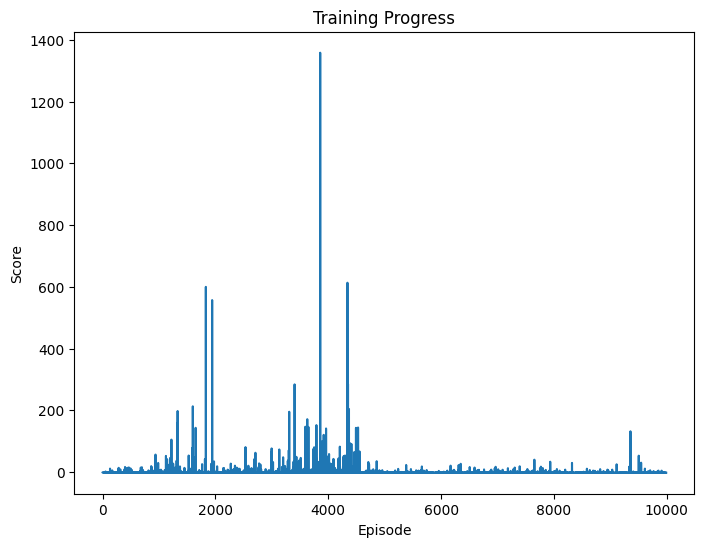

Episode: 9990, Score: -2, Epsilon: 0.01


In [51]:
env = AdvancedPongEnv()

# Load existing model and initialize new model
base_model = DQN(input_size=5, output_size=3)
base_model.load_state_dict(torch.load('pong_modeladv.pth'))

trained_model = DQN(input_size=5, output_size=3)
trained_model.load_state_dict(base_model.state_dict())

trained_model, training_scores = train(env, render_frequency=10)
torch.save(trained_model.state_dict(), 'pong_modeladv.pth')

In [10]:
test_env = PongEnv()
test_model(trained_model, test_env)

Test Episode 1: Score = 3
Test Episode 2: Score = 13

Testing interrupted
